In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from hcmus.core import appconfig
from hcmus.utils import viz_utils
from hcmus.lbs import LabelStudioConnector
from hcmus.data import CroppedObjectClassificationDataset

2025-06-15 11:19:54.042 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import mlflow
experiment_name = "/MatchingNetwork"
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = None
if not experiment:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

In [4]:
accepted_labels = """
8934804026817-nuoc-tuong-maggi-dau-nanh-thanh-diu-chai-700ml
8934804020402-nuoc-tuong-maggi-dau-nanh-dam-dac-700ml
8936048470524-mi-tom-3-mien-gold-vi-bo-ham-rau-thom-75g
8934822201272-bia-heineken-silver-lon-250ml
5054563022592-kem-danh-rang-sensodyne-giam-e-buotlam-sang-rang-100g
8934868166344-nuoc-rua-tay-lifebouy-450ml
8934707029182-hat-nem-knorr-thit-than-xuong-ong-va-tuy-900g
8934822361211-bia-heineken-khong-con-lon-330ml
8850006932346-kem-danh-rang-colgate-maxfresh-huong-tra-xanh-225g-+-ban-chai-long-to
8850006932322-kem-danh-rang-colgate-maxfresh-huong-bac-ha-225g-+-ban-chai-long-to
6920354827792-kem-danh-rang-colgate-maxfresh-tinh-chat-than-tre-225g-+-ban-chai-long-to
8936136163314-nuoc-mam-nam-ngu-3-trong-1-750ml
8934563198152-mi-hao-hao-chay-vi-rau-nam-74gr
8935049501503-nuoc-ngot-coca-cola-vi-nguyen-ban-lon-320ml
8936048470036-mi-3-mien-mi-chay-la-da-65g-(goi)
8935001215028-tra-tea-break-milk-350ml
8935006532755-kem-rua-mat-acnes-vitamin-lam-sang-da,-mo-seo-tham-50g
8935018801641-khan-bep-da-nang-pulppy-classic-2-lop-loc-2-cuon
8935024123287-ca-phe-sua-hoa-tan-g7-3in1-hop-336g-(16g-x-21-goi)
8935006538634-dau-tay-trang-hada-labo-sach-sau-duong-am-toi-uu-200ml
8934840000093-nuoc-khoang-chanh-lemona-chai-500ml
8997035601321-nuoc-uong-bu-dien-giai-bo-sung-ion-pocari-sweat-chai-900ml
4897036693162-nuoc-tang-luc-monster-mango-loco-355ml
809939073648-soda-sua-huong-vi-chuoi-milkis-banana
8934804038131-tra-hoa-qua-nestea-hoa-tan-hop-144g-12-goi-x-12g
8936048471248-mi-tom-chua-cay-dac-biet-3-mien-gold-goi-75g
8934804027333-tra-chanh-nestea-hoa-tan-hop-195g-15-goi-x-13g
8936010530881-tra-chanh-cozy-hoa-tan-hop-240g-16-goi-x-15g
8935049510604-nuoc-ngot-sprite-chai-320ml
8934588672118-nuoc-ngot-pepsi-khong-calo-vi-chanh-320ml
8935049501572-nuoc-ngot-fanta-vi-cam-lon-320ml
8935049500445-nuoc-ngot-fanta-chai-1.5l
8936721790017-nuoc-loc-th-true-water-chai-500ml
8935049501718-nuoc-ngot-sprite-lon-320ml
8936193070013-tra-xanh-khong-do-500ml
8935137601122-tra-xanh-thai-nguyen-100g
8934564600883-tra-den-c2-vi-dua-luoi-chai-455ml
8935001214274-tra-bi-dao-wonderfarm-lon-310ml
8934588870552-tra-olong-teaplus-450ml
6920354836930-kem-danh-rang-colgate-optic-white-cong-nghe-sac-tim-100g
8935049501374-nuoc-ngot-cocacola-vi-nguyen-ban-chai-600ml
8935039570700-ca-phe-sua-robusta-birdy-lon-170ml
8934673701402-nuoc-dao-necta-vinamilk-hop-1l
8935005801012-nuoc-loc-lavie-chai-1-5l
8936079140021-ca-phe-sua-highland-coffee-lon-185ml
8934588640445-ca-phe-sua-boss-lon-180ml
8934683008614-ca-phe-sua-vinacafe-3-in-1-gold-tui-480g-24-goi-tui
8934683008867-nuoc-tang-luc-wake-up-247-vi-ca-phe-330ml
8935328600156-tra-xanh-tui-loc-phuc-long-2g-x-hop-25-goi
4902430805322-nuoc-rua-tay-diet-khuan-safeguard-trang-tinh-khiet-450ml
8936156730718-nuoc-xa-vai-blue-dam-dac-huong-thanh-xuan-tui-3.2l
8934868166825-dau-goi-sunsilk-natural-duong-ngan-gay-rung-650g
8934804040523-tra-vai-va-huong-hoa-lai-nestea-hoa-tan-hop-144g-12-goi-x-12g
8934822801335-bia-tiger-crystal-4-6-phan-tram-lon-330ml
8934868156871-dau-xa-sunsilk-mem-muot-dieu-ky-320g
8936010530713-tra-dao-cozy-hoa-tan-hop-16-goi-x-15g
8934868171850-nuoc-lau-kinh-sunlight-sieu-nhanh-sach-trong-suot-chai-520ml
8850228003541-nuoc-tang-luc-warrior-huong-dau-chai-330ml
8936193070075-nuoc-tang-luc-number-1-chai-330ml
8934588012112-nuoc-ngot-pepsi-cola-320ml
8936013254951-nuoc-rua-kinh-gift-540ml
8934868190394-nuoc-giat-comfort-huong-hoa-anh-dao-va-dao-tuoi-tui-3kg
3068320055008-nuoc-loc-evivan-chai-500ml
8936127794206-nuoc-uong-sua-trai-cay-th-true-juice-milk-huong-viet-quat-300ml
8935049511038-sua-trai-cay-nutriboost-cam-chai-1l
8934673573399-sua-tuoi-tiet-trung-co-duong,-100%-sua-tuoivinamilk-(1lit).
3760128640607-sua-tuoi-tiet-trung-promess-nguyen-kem-hop-1l
8934822212339-bia-heineken-lon-cao-330ml
8801382123446-nuoc-gao-han-quoc-loai-500ml
8936036201604-bia-hoegaarden-rosee-chai-248ml
8934692090013-bia-1664-blanc-5%-abv-chai-330ml
8934868166870-dau-goi-sunsilk-ong-muot-rang-ngoi-chai-650g
8934588233074-nuoc-tang-luc-sting-vi-dau-tay-do-330ml
8934822431211-bia-tiger-soju-infused-lager-wonder-melon-vi-dua-luoi-lon-330ml
8934822112332-bia-tiger-lon-cao-330ml-lon
8934868180470-dau-goi-dove-biotin-ngan-gay-rung-toc-880g
8935024170519-ca-phe-trung-nguyen-legend-classic-hop-357g-17g-x-21-goi
8934868166351-nuoc-rua-tay-lifebuoy-matcha-va-lo-hoichai-450g
8936191270057-ca-phe-cappuccino-dua-just-viet-hop-hop-10-goi-x-17g
8934868166924-dau-goi-sunsilk-mem-muot-dieu-ky-chai-650g
8934804028064-ca-phe-hoa-tan-nescafe-3in1-vi-nguyen-ban-tui-782g-(17g-x-46-goi)
8936122200276-ca-phe-mr.brown-blue-mountain-240ml
8934563122201-mi-hao-hao-vi-tom-chua-cay-goi-100g
8935136865709-sua-tam-purite-duong-da-mem-min-huong-hoa-hong-rose-chai-850ml
8934822451295-nuoc-trai-cay-len-men-strongbow-vi-thom-luu-3.5%-lon-330ml
8934868170990-nuoc-rua-tay-lifebuoy-vitamin-sua-duong-am-tui-1kg
8936094291005-bia-budweiser-5-lon-330ml
8934822121297-nuoc-trai-cay-len-men-strongbow-red-beries-4.5%-abv-lon-320ml
8934822111298-nuoc-trai-cay-len-men-strongbow-gold-apple-4-5-abv-lon-320ml
8935049501190-nuoc-tra-fuze-tea-vi-chanh-sa-450ml
8936199810026-cafe-the-coffee-house-sua-da-22gx10-goi-(hop)
8888589308920-tra-bi-dao-winter-melon-jj-lon-300ml
8934673101097-sua-tuoi-tiet-trung-tiet-trung-vinamilk-khong-duong-bich-220ml
8934563183158-mi-hao-hao-sa-te-hanh-tim-75g
8936048470012-mi-3-mien-tom-chua-cay-65g
8934683009925-ca-phe-sua-da-vinacafe-chat-hop-10-goi-24g
8850228007617-nuoc-tang-luc-redbull-250ml
8934563651138-mi-hao-hao,-vi-tom-chua-cayacecook,-coc-(67g)
8934588063060-nuoc-loc-aquafina-chai-1-5l
8935049510857-nuoc-loc-dasani-chai-1.5l"""
accepted_labels = accepted_labels.splitlines()
accepted_labels = [x for x in accepted_labels if len(x) > 0]

In [5]:
splits = {}
for split_name in ["train", "test", "val"]:
    lsb_connector = LabelStudioConnector(
        url=appconfig.LABEL_STUDIO_URL,
        api_key=appconfig.LABEL_STUDIO_API_KEY,
        project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING[split_name],
        temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
    )

    tasks = lsb_connector.get_tasks()
    labels = lsb_connector.extract_labels(tasks)
    dataset = lsb_connector.download_dataset(tasks, labels)
    dataset = lsb_connector.transform_labels(dataset, labels, accepted_labels)
    splits[split_name] = dataset

2025-06-15 11:19:56.310 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:144 - Page size is too large, only 3308 tasks available.
2025-06-15 11:19:56.311 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:148 - New `page_to` applied: 34
Loading tasks: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]
2025-06-15 11:20:12.577 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:144 - Page size is too large, only 355 tasks available.
2025-06-15 11:20:12.577 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:148 - New `page_to` applied: 4
Loading tasks: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
2025-06-15 11:20:16.256 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:144 - Page size is too large, only 83 tasks available.
2025-06-15 11:20:16.256 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:148 - New `page_to` applied: 1
Loading tasks: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


In [145]:
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

In [146]:
import numpy as np
from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from hcmus.data import CroppedFewShotDataset
device = "cpu"
batch_size = 32
skip_labels = [
    "object",
    "8936136163314-nuoc-mam-nam-ngu-3-trong-1-750ml",
    "8936079140021-ca-phe-sua-highland-coffee-lon-185ml",
    "8936048470012-mi-3-mien-tom-chua-cay-65g",
    "8934822111298-nuoc-trai-cay-len-men-strongbow-gold-apple-4-5-abv-lon-320ml",
    "8936036201604-bia-hoegaarden-rosee-chai-248ml",
    "8934673101097-sua-tuoi-tiet-trung-tiet-trung-vinamilk-khong-duong-bich-220ml",
    "8801382123446-nuoc-gao-han-quoc-loai-500ml",
    "5054563022592-kem-danh-rang-sensodyne-giam-e-buotlam-sang-rang-100g",
    "8850006932322-kem-danh-rang-colgate-maxfresh-huong-bac-ha-225g-+-ban-chai-long-to",
]
train_dataset = CroppedFewShotDataset(splits["train"], skip_labels=skip_labels, transforms=transform_train)
val_dataset = CroppedFewShotDataset(splits["val"], label2idx=train_dataset.label2idx, transforms=transform_basic, is_test=True)
n_way = len(train_dataset.known_classes)
train_sampler = TaskSampler(
    dataset=train_dataset,
    n_way=n_way,
    n_shot=10,
    n_query=0,
    n_tasks=1
)
train_dataloader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.episodic_collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False
)

2025-06-15 15:05:41.408 | INFO     | hcmus.data._torch_dataset:__init__:156 - Auto infer `label2idx` mapping, mapping length: 90.


In [147]:
s_images, s_labels, _, _, u_labels = next(iter(train_dataloader))

In [148]:
def precision_at_k(y_true, y_pred_ranked, k):
    assert len(y_true) == len(y_pred_ranked), "Mismatch in number of samples"
    correct = 0

    for true_label, pred_list in zip(y_true, y_pred_ranked):
        if true_label in pred_list[:k]:
            correct += 1

    return correct / len(y_true)

In [149]:
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from hcmus.models.fewshot import MatchingNetwork

def evaluate_backbone(backbone_name: str, is_hf: bool, emb_size: int):
    with mlflow.start_run(experiment_id=experiment_id, run_name=backbone_name):
        print(f"Backbone: {backbone_name}")

        model = MatchingNetwork(backbone_name, s_images, s_labels, is_hf=is_hf, emb_size=emb_size)
        L_true = []
        L_pred = []
        D_pred = []
        for q_images, q_labels in tqdm(val_dataloader, "Evaluating..."):
            tmp = model.predict(q_images, k=5)
            L_pred.extend([x["L"] for x in tmp])
            D_pred.extend([x["D"] for x in tmp])
            L_true.extend(q_labels.detach().numpy())

        known_idx = [i for i, x in enumerate(L_true) if x != -1]
        unknown_idx = [i for i, x in enumerate(L_true) if x == -1]
        L_pred_known = [L_pred[i] for i in known_idx]
        L_true_known = [L_true[i] for i in known_idx]
        D_pred_unknown = [D_pred[i] for i in unknown_idx]
        D_pred_known = [D_pred[i] for i in known_idx]
        p_at_1 = precision_at_k(L_true_known, L_pred_known, 1)
        p_at_3 = precision_at_k(L_true_known, L_pred_known, 3)
        p_at_5 = precision_at_k(L_true_known, L_pred_known, 5)
        mlflow.log_param("backbone", backbone_name)
        mlflow.log_metrics({
            "precision_at_1": p_at_1,
            "precision_at_3": p_at_3,
            "precision_at_5": p_at_5,
            "D_known_min": np.min(D_pred_known),
            "D_known_max": np.max(D_pred_known),
            "D_known_mean": np.mean(D_pred_known),
            "D_known_median": np.median(D_pred_known),
            "D_known_p90": np.quantile(D_pred_known, 0.9),
            "D_known_p95": np.quantile(D_pred_known, 0.95),
            "D_known_p99": np.quantile(D_pred_known, 0.99),
            "D_unknown_min": np.min(D_pred_unknown),
            "D_unknown_max": np.max(D_pred_unknown),
            "D_unknown_mean": np.mean(D_pred_unknown),
            "D_unknown_median": np.median(D_pred_unknown),
            "D_unknown_p90": np.quantile(D_pred_unknown, 0.9),
            "D_unknown_p95": np.quantile(D_pred_unknown, 0.95),
            "D_unknown_p99": np.quantile(D_pred_unknown, 0.99),
        })

In [150]:
backbone_list = [
    # "resnet50",
    # "densenet121",
    # "densenet169",
    # "efficientnet_b0",
    # "efficientnet_b3",
    # "convnext_tiny",
    # "convnext_small",
    # "mobilenetv3_large_100",
    # "vit_base_patch16_224",
    # "deit_small_patch16_224",
    # "swin_tiny_patch4_window7_224",
    # "beit_base_patch16_224",
    # "coat_lite_tiny",
    {
        "backbone_name": "openai/clip-vit-base-patch16",
        "is_hf": True,
        "emb_size": 512
    }
]
for backbone in backbone_list:
    evaluate_backbone(**backbone)
    # print(eval_result)
    # result_dict.append(eval_result)

Backbone: openai/clip-vit-base-patch16


Building index: 100%|██████████| 900/900 [00:43<00:00, 20.86it/s]
2025-06-15 15:06:43.393 | INFO     | hcmus.models.fewshot:__init__:40 - Index shape: 900
Evaluating...: 100%|██████████| 369/369 [01:23<00:00,  4.44it/s]


🏃 View run openai/clip-vit-base-patch16 at: http://jimica.ddns.net:5050/#/experiments/668891575728943430/runs/0939837d320a45e5b159e4e9c5babf0b
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/668891575728943430


In [156]:
model = MatchingNetwork(**backbone_list[0], support_images=s_images, support_labels=s_labels)

Building index: 100%|██████████| 900/900 [00:42<00:00, 20.94it/s]
2025-06-15 15:10:12.965 | INFO     | hcmus.models.fewshot:__init__:40 - Index shape: 900


In [152]:
val_iter = iter(val_dataloader)

In [159]:
q_images, q_labels = next(val_iter)
q_labels

tensor([18, 18, 83, 83])

In [160]:
for i, s_label in enumerate(s_labels):
    if s_label == 18:
        print(i)

570
571
572
573
574
575
576
577
578
579


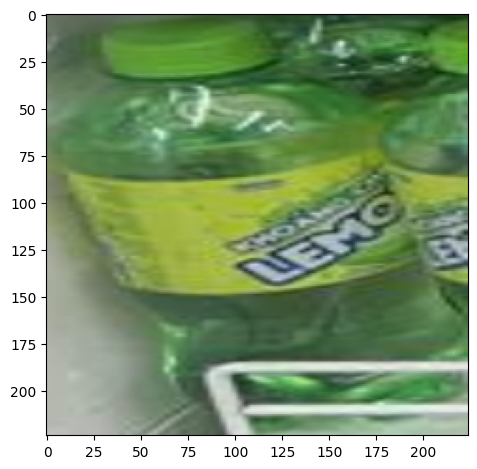

In [162]:
viz_utils.plot_image(q_images[0].detach().numpy().transpose(1, 2, 0))

In [167]:
t1 = model.create_embeddings(q_images[0].unsqueeze(0))
t2 = model.create_embeddings(s_images[700].unsqueeze(0))
t3 = model.create_embeddings(s_images[329].unsqueeze(0))
# t2 = model.create_embeddings()

In [171]:
model.predict(q_images)

[{'D': array([0.00057337, 0.00070851, 0.00081837], dtype=float32),
  'I': array([463, 279, 332]),
  'L': [86, 28, 1]},
 {'D': array([0.0007554 , 0.00090943, 0.00106837], dtype=float32),
  'I': array([463, 584, 332]),
  'L': [86, 55, 1]},
 {'D': array([0.00058599, 0.00096921, 0.00119164], dtype=float32),
  'I': array([584, 463, 805]),
  'L': [55, 86, 36]},
 {'D': array([0.00096421, 0.00096542, 0.00102015], dtype=float32),
  'I': array([273, 805, 366]),
  'L': [28, 36, 23]}]